In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as pp
import seaborn as sb


In [5]:
project_path = Path.cwd()
data_path = project_path / 'data' / '04_transformed'
assert data_path.exists()

In [63]:
df.head()

,id,Rrs411,Rrs443,Rrs489,Rrs510,Rrs555,Rrs670,MBR,log_MBR,MBR_flag,chl,log_chl,hplc_flag
0,1565,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,0.368826,-0.433178,Rrs510,38.19,1.581950,0
1,1566,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,0.427444,-0.369121,Rrs510,35.01,1.544192,0
2,1567,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,0.390537,-0.408338,Rrs510,26.91,1.429914,0
3,1568,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,0.358694,-0.445276,Rrs510,47.96,1.680879,0
4,1559,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,0.414576,-0.382395,Rrs510,23.55,1.371991,0


In [6]:
df = pd.read_parquet(data_path / 'df_all.pqt')

<Axes: >

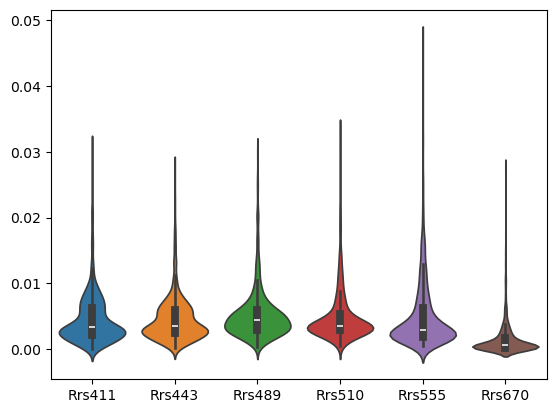

In [7]:
sb.violinplot(df.filter(regex='Rrs[0-9]+'))

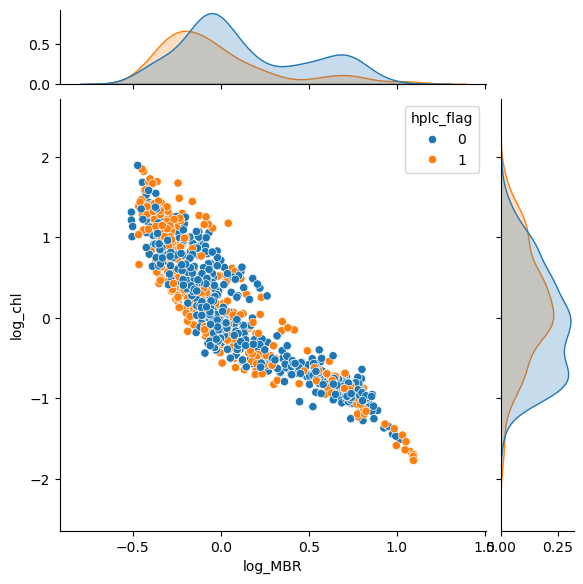

In [ ]:
sb.jointplot(
    df, x='log_MBR', y='log_chl', hue='hplc_flag', 
    hue_order=['0', '1'], dropna=True, )

In [24]:
import cmocean.cm as cmo

In [33]:
import matplotlib.colors as mc

In [38]:
wavelength_colors = {
    '411': mc.to_rgb('indigo'),  # Approximate color for 411 nm
    '443': mc.to_rgb('blue'),       # Approximate color for 443 nm
    '489': mc.to_rgb('cyan'),       # Approximate color for 489 nm
    '510': mc.to_rgb('green')        # Approximate color for 510 nm
}
wavelengths= [f'{i}' for i in wavelength_colors.keys()]
# Create a custom palette mapping wavelengths to colors
palette = [wavelength_colors[w] for w in np.unique(wavelengths)]
hue_order = [f'Rrs{i}' for i in wavelengths]

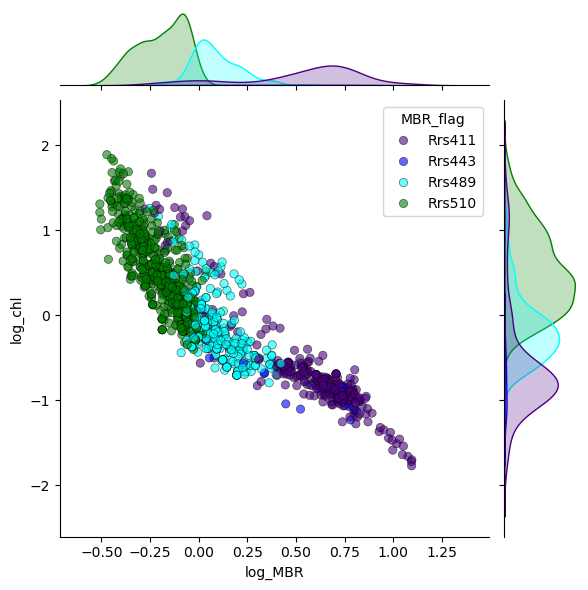

In [64]:
sb.jointplot(
    df, x='log_MBR', y='log_chl', hue='MBR_flag', 
    hue_order=['Rrs411', 'Rrs443', 'Rrs489', 'Rrs510'], palette=palette,
        joint_kws={'alpha': 0.6, 'edgecolor': 'k'}    # dropna=True, 
    )

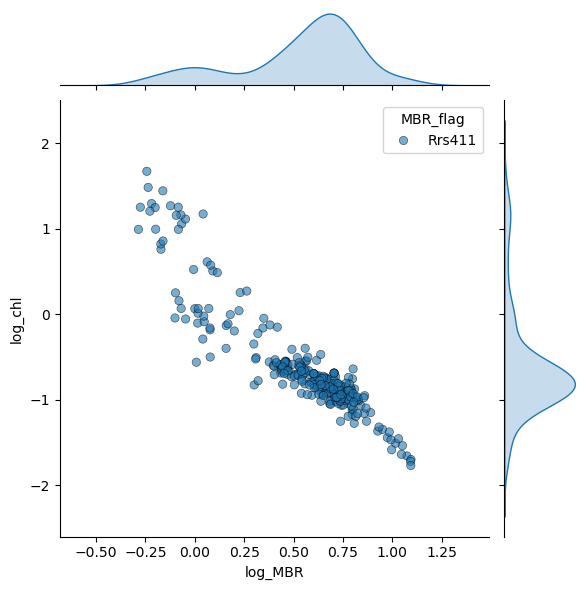

In [46]:
flag='Rrs411'
sb.jointplot(
    df.loc[df.MBR_flag==flag], x='log_MBR', y='log_chl', hue='MBR_flag', 
        joint_kws={'alpha': 0.6, 'edgecolor': 'k'}    # dropna=True, 
    )

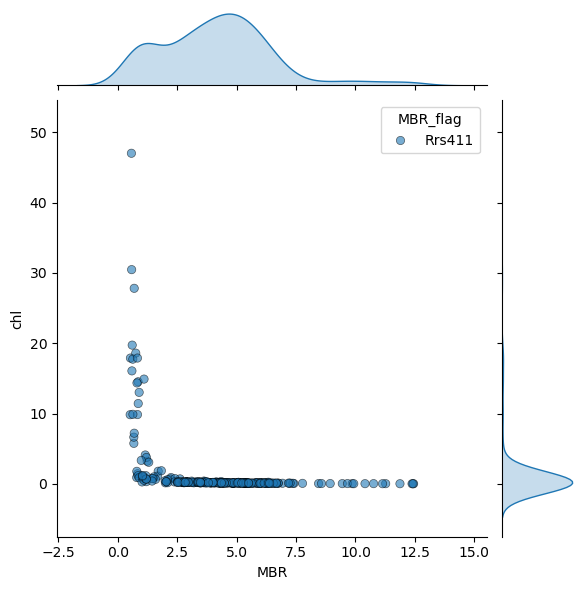

In [48]:
flag='Rrs411'
sb.jointplot(
    df.loc[df.MBR_flag==flag], x='MBR', y='chl', hue='MBR_flag', 
        joint_kws={'alpha': 0.6, 'edgecolor': 'k'}    # dropna=True, 
    )

In [50]:
import scipy.stats as stats

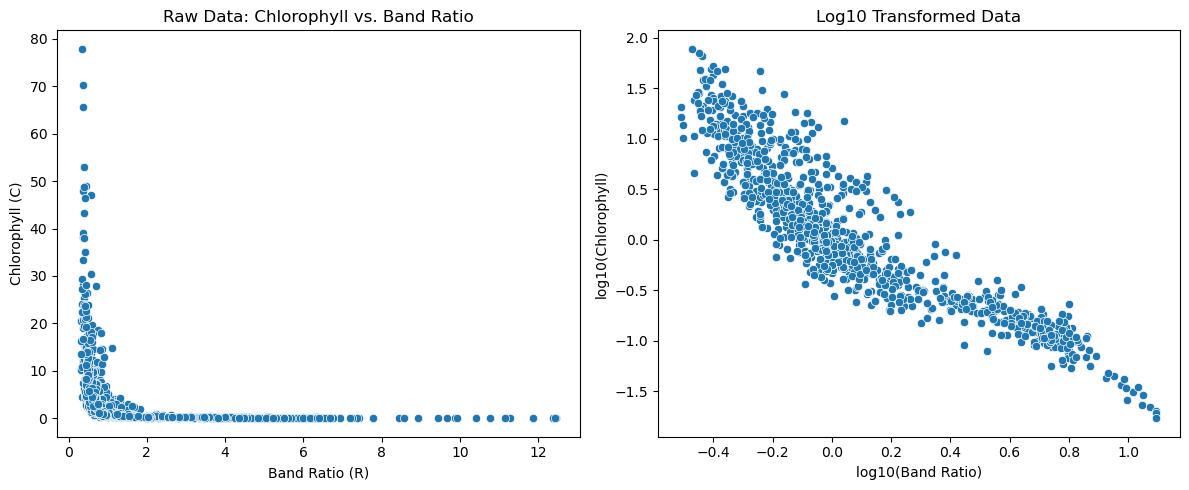

Optimal lambda for Band Ratio (R): -0.5289547889414822
Optimal lambda for Chlorophyll (C): -0.040094636464585616


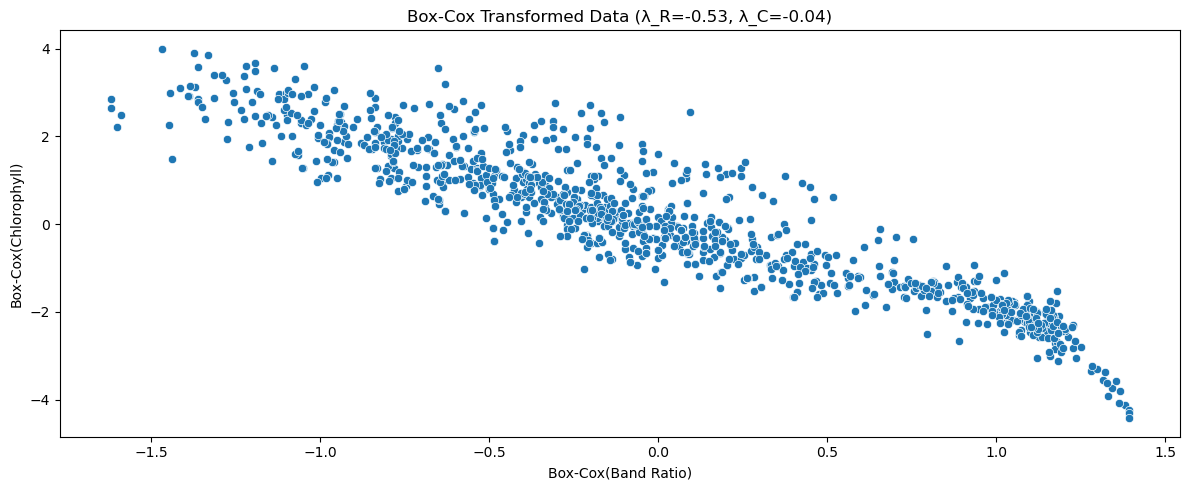

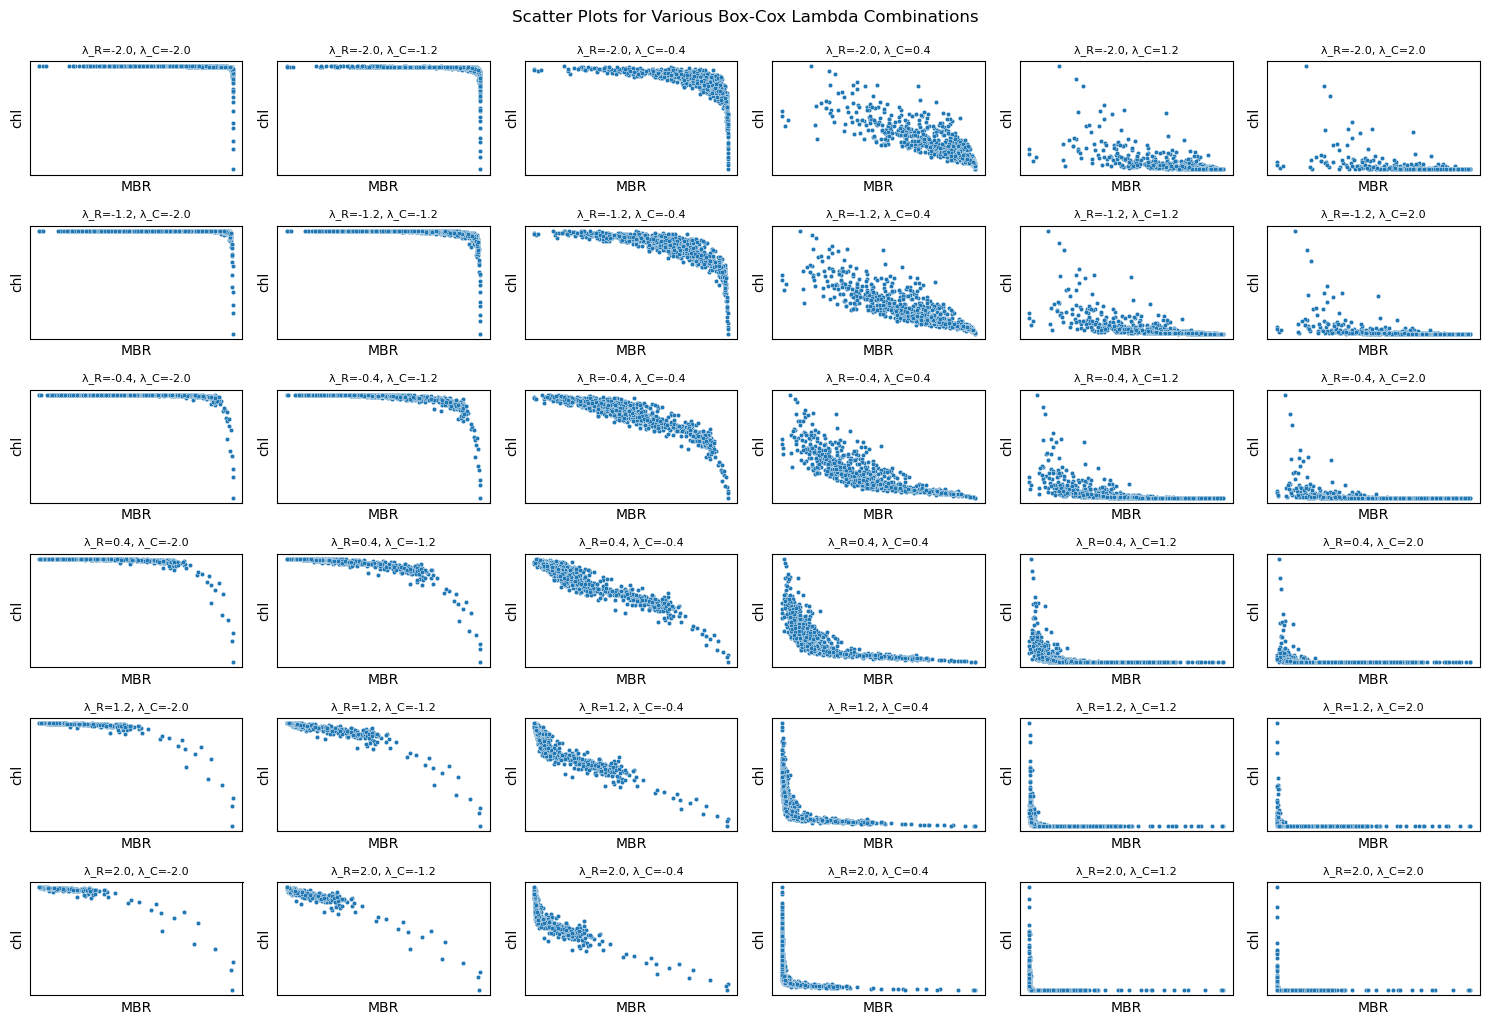

In [62]:
R_series = df.dropna().MBR
C_series = df.dropna().chl
# 1. Visualize the raw data
pp.figure(figsize=(12, 5))
pp.subplot(1, 2, 1)
sb.scatterplot(x=R_series, y=C_series)
pp.title("Raw Data: Chlorophyll vs. Band Ratio")
pp.xlabel("Band Ratio (R)")
pp.ylabel("Chlorophyll (C)")

# 2. Visualize the log10-transformed data (your initial step)
pp.subplot(1, 2, 2)
sb.scatterplot(x=np.log10(R_series), y=np.log10(C_series))
pp.title("Log10 Transformed Data")
pp.xlabel("log10(Band Ratio)")
pp.ylabel("log10(Chlorophyll)")
pp.tight_layout()
pp.show()

# 3. Apply Box-Cox transformation to each variable independently
R_transformed, R_lambda = stats.boxcox(R_series)
C_transformed, C_lambda = stats.boxcox(C_series)

print(f"Optimal lambda for Band Ratio (R): {R_lambda}")
print(f"Optimal lambda for Chlorophyll (C): {C_lambda}")

# Convert transformed data back to pandas Series for easier handling
R_transformed_series = pd.Series(R_transformed, index=R_series.index)
C_transformed_series = pd.Series(C_transformed, index=C_series.index)

# 4. Visualize the Box-Cox transformed data
pp.figure(figsize=(12, 5))
sb.scatterplot(x=R_transformed_series, y=C_transformed_series)
pp.title(f"Box-Cox Transformed Data (λ_R={R_lambda:.2f}, λ_C={C_lambda:.2f})")
pp.xlabel("Box-Cox(Band Ratio)")
pp.ylabel("Box-Cox(Chlorophyll)")
pp.tight_layout()
pp.show()

# 5. Explore a range of lambda values (optional but can be informative)
lambdas_to_test = np.linspace(-2, 2, 6) # Test lambdas from -2 to 2

pp.figure(figsize=(15, 10))
for i, lmbda_r in enumerate(lambdas_to_test):
    for j, lmbda_c in enumerate(lambdas_to_test):
        if i * len(lambdas_to_test) + j + 1 <= len(lambdas_to_test)**2:
            pp.subplot(len(lambdas_to_test), len(lambdas_to_test), i * len(lambdas_to_test) + j + 1)
            if lmbda_r == 0:
                R_trans_test = np.log(R_series)
            else:
                R_trans_test = (R_series**lmbda_r - 1) / lmbda_r

            if lmbda_c == 0:
                C_trans_test = np.log(C_series)
            else:
                C_trans_test = (C_series**lmbda_c - 1) / lmbda_c

            sb.scatterplot(x=R_trans_test, y=C_trans_test, s=10)
            pp.title(f"λ_R={lmbda_r:.1f}, λ_C={lmbda_c:.1f}", fontsize=8)
            pp.xticks([])
            pp.yticks([])

pp.tight_layout()
pp.suptitle("Scatter Plots for Various Box-Cox Lambda Combinations", y=1.02)
pp.show()

In [53]:
import pymc as pm

R = df.MBR
C = df.chl

In [59]:
import pytensor.tensor as pt

In [ ]:
pt.power()

In [60]:
with pm.Model() as model:
    # Priors for the Box-Cox lambda parameters
    lambda_R = pm.Normal("lambda_R", mu=1, sigma=1)  # You might need to adjust these priors
    lambda_C = pm.Normal("lambda_C", mu=1, sigma=1)

    # Define the Box-Cox transformation within the PyMC model
    def boxcox_transform(x, lmbda):
        return (pt.pow(x, lmbda) - 1) / lmbda

    transformed_R = pm.Deterministic("transformed_R", boxcox_transform(R, lambda_R))
    transformed_C = pm.Deterministic("transformed_C", boxcox_transform(C, lambda_C))

    # Priors for the linear model parameters
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    # Linear model likelihood
    mu = intercept + slope * transformed_R
    likelihood = pm.Normal("transformed_C_obs", mu=mu, sigma=sigma, observed=transformed_C)

    # Perform inference
    trace = pm.sample(2000, tune=1000, chains=4)

# Analyze the results
pm.summary(trace)
pm.plot_trace(trace, var_names=["lambda_R", "lambda_C", "intercept", "slope", "sigma"])
pp.show()

TypeError: Variables that depend on other nodes cannot be used for observed data.The data variable was: transformed_C

In [44]:
df.MBR_flag.value_counts()

MBR_flag
Rrs510    589
Rrs489    315
Rrs411    296
Rrs443     13
Name: count, dtype: int64

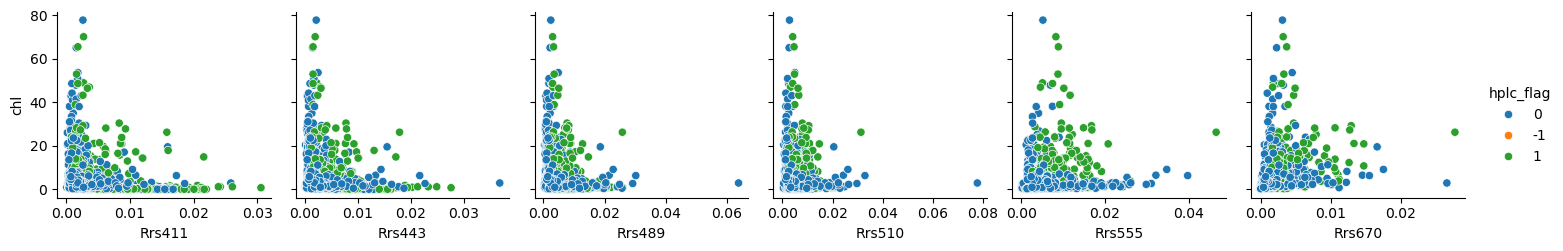

In [ ]:
sb.pairplot(
    df, x_vars=[f'Rrs{i}' for i in [411, 443, 489, 510, 555, 670]], y_vars='chl', hue='hplc_flag')

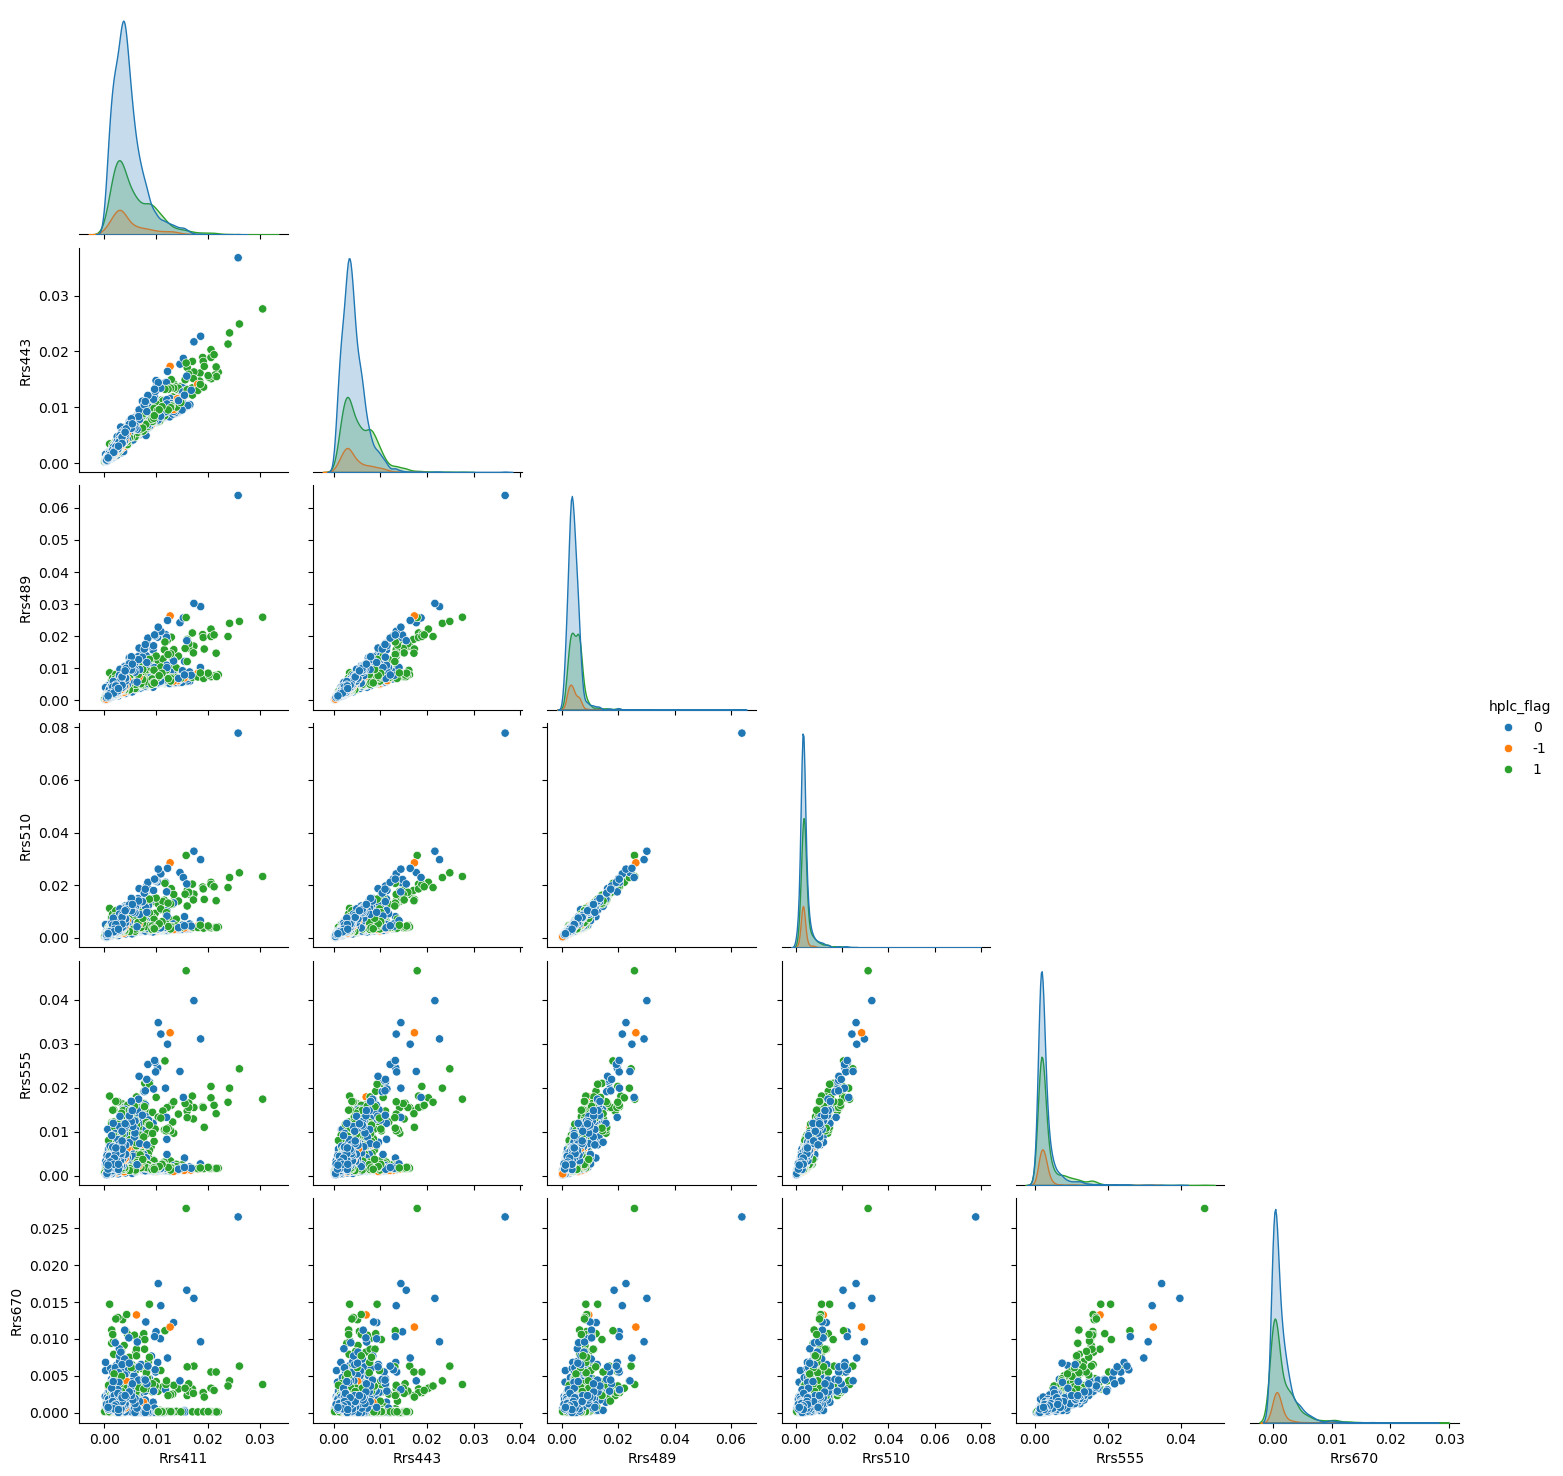

In [94]:
sb.pairplot(df, vars=[f'Rrs{i}' for i in [411, 443, 489, 510, 555, 670]], hue='hplc_flag', corner=True)

In [16]:
corr

,Rrs411,Rrs443,Rrs489,Rrs510,Rrs555,Rrs670,chl
Rrs411,1.000000,0.959722,0.683267,0.379516,0.096205,0.183005,-0.292793
Rrs443,0.959722,1.000000,0.834276,0.586472,0.286469,0.256675,-0.288902
Rrs489,0.683267,0.834276,1.000000,0.925296,0.709095,0.547514,-0.159954
Rrs510,0.379516,0.586472,0.925296,1.000000,0.917634,0.705633,0.046809
Rrs555,0.096205,0.286469,0.709095,0.917634,1.000000,0.850907,0.303005
Rrs670,0.183005,0.256675,0.547514,0.705633,0.850907,1.000000,0.370348
chl,-0.292793,-0.288902,-0.159954,0.046809,0.303005,0.370348,1.000000


In [36]:
def plot_triu_heatmap(df: pd.DataFrame):
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = pp.subplots()
    sb.heatmap(df, mask=mask, ax=ax)
    ax.set_xlim(0, 6)
    ax.set_ylim(7, 1)

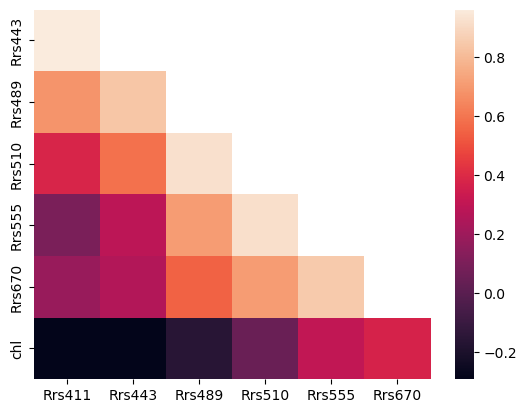

In [38]:
corr = df.drop(['id', 'hplc_flag'], axis=1).corr()
plot_triu_heatmap(corr)

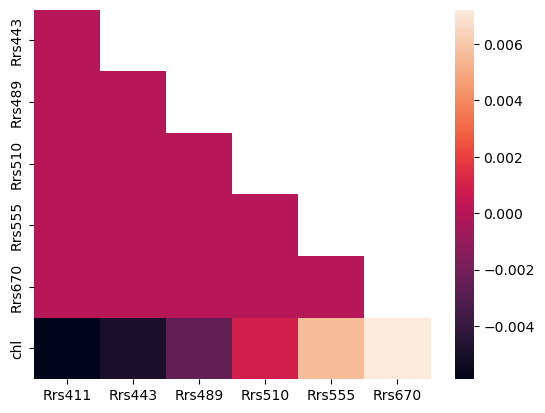

In [39]:
cov = df.drop(['id', 'hplc_flag'], axis=1).cov()
plot_triu_heatmap(cov)

In [48]:
df.filter(regex='Rrs[0-9]+', axis=1).describe()

,Rrs411,Rrs443,Rrs489,Rrs510,Rrs555,Rrs670
count,4293.000000,4456.000000,4422.000000,3435.000000,3255.000000,1598.000000
mean,0.004881,0.004652,0.004590,0.004130,0.003256,0.001557
std,0.003447,0.003002,0.002768,0.003130,0.003536,0.002387
min,0.000051,0.000190,0.000284,0.000261,0.000183,0.000000
25%,0.002509,0.002617,0.003051,0.002831,0.001588,0.000200
50%,0.003984,0.003899,0.004153,0.003425,0.002071,0.000614
75%,0.006301,0.006076,0.005655,0.004242,0.003141,0.002000
max,0.030600,0.036769,0.063814,0.077740,0.046600,0.027700


<Axes: >

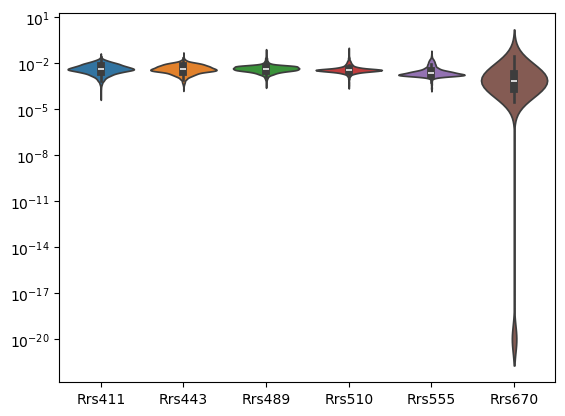

In [90]:
sb.violinplot(df.filter(regex='Rrs[0-9]+')+ 1e-20,log_scale=True)

In [54]:
df.hplc_flag.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4459 entries, 0 to 4458
Series name: hplc_flag
Non-Null Count  Dtype 
--------------  ----- 
4459 non-null   object
dtypes: object(1)
memory usage: 35.0+ KB


In [97]:
df_ = df[df.Rrs670>0].dropna()

In [98]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 4458
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1016 non-null   int64  
 1   Rrs411     1016 non-null   float64
 2   Rrs443     1016 non-null   float64
 3   Rrs489     1016 non-null   float64
 4   Rrs510     1016 non-null   float64
 5   Rrs555     1016 non-null   float64
 6   Rrs670     1016 non-null   float64
 7   chl        1016 non-null   float64
 8   hplc_flag  1016 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 79.4+ KB


In [99]:
df_log = np.log(df_.filter(regex='Rrs[0-9]'))
df_log['chl'] = np.log(df_.chl)
df_log['hplc_flag'] = df_.hplc_flag

In [ ]:
df_log.rename(columns={'chl': 'log_chl'}, inplace=True)
df_log.rename(columns ={f'Rrs{i}': f'log_rrs{i}' for i in [411, 443, 489, 510, 555, 670]}, inplace=True)

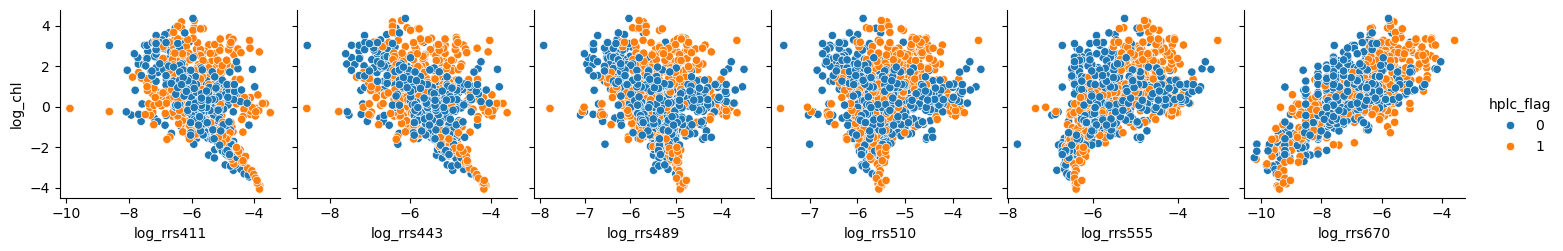

In [109]:
sb.pairplot(df_log, x_vars=[f'log_rrs{i}' for i in [411, 443, 489, 510, 555, 670]], y_vars='log_chl', hue='hplc_flag');

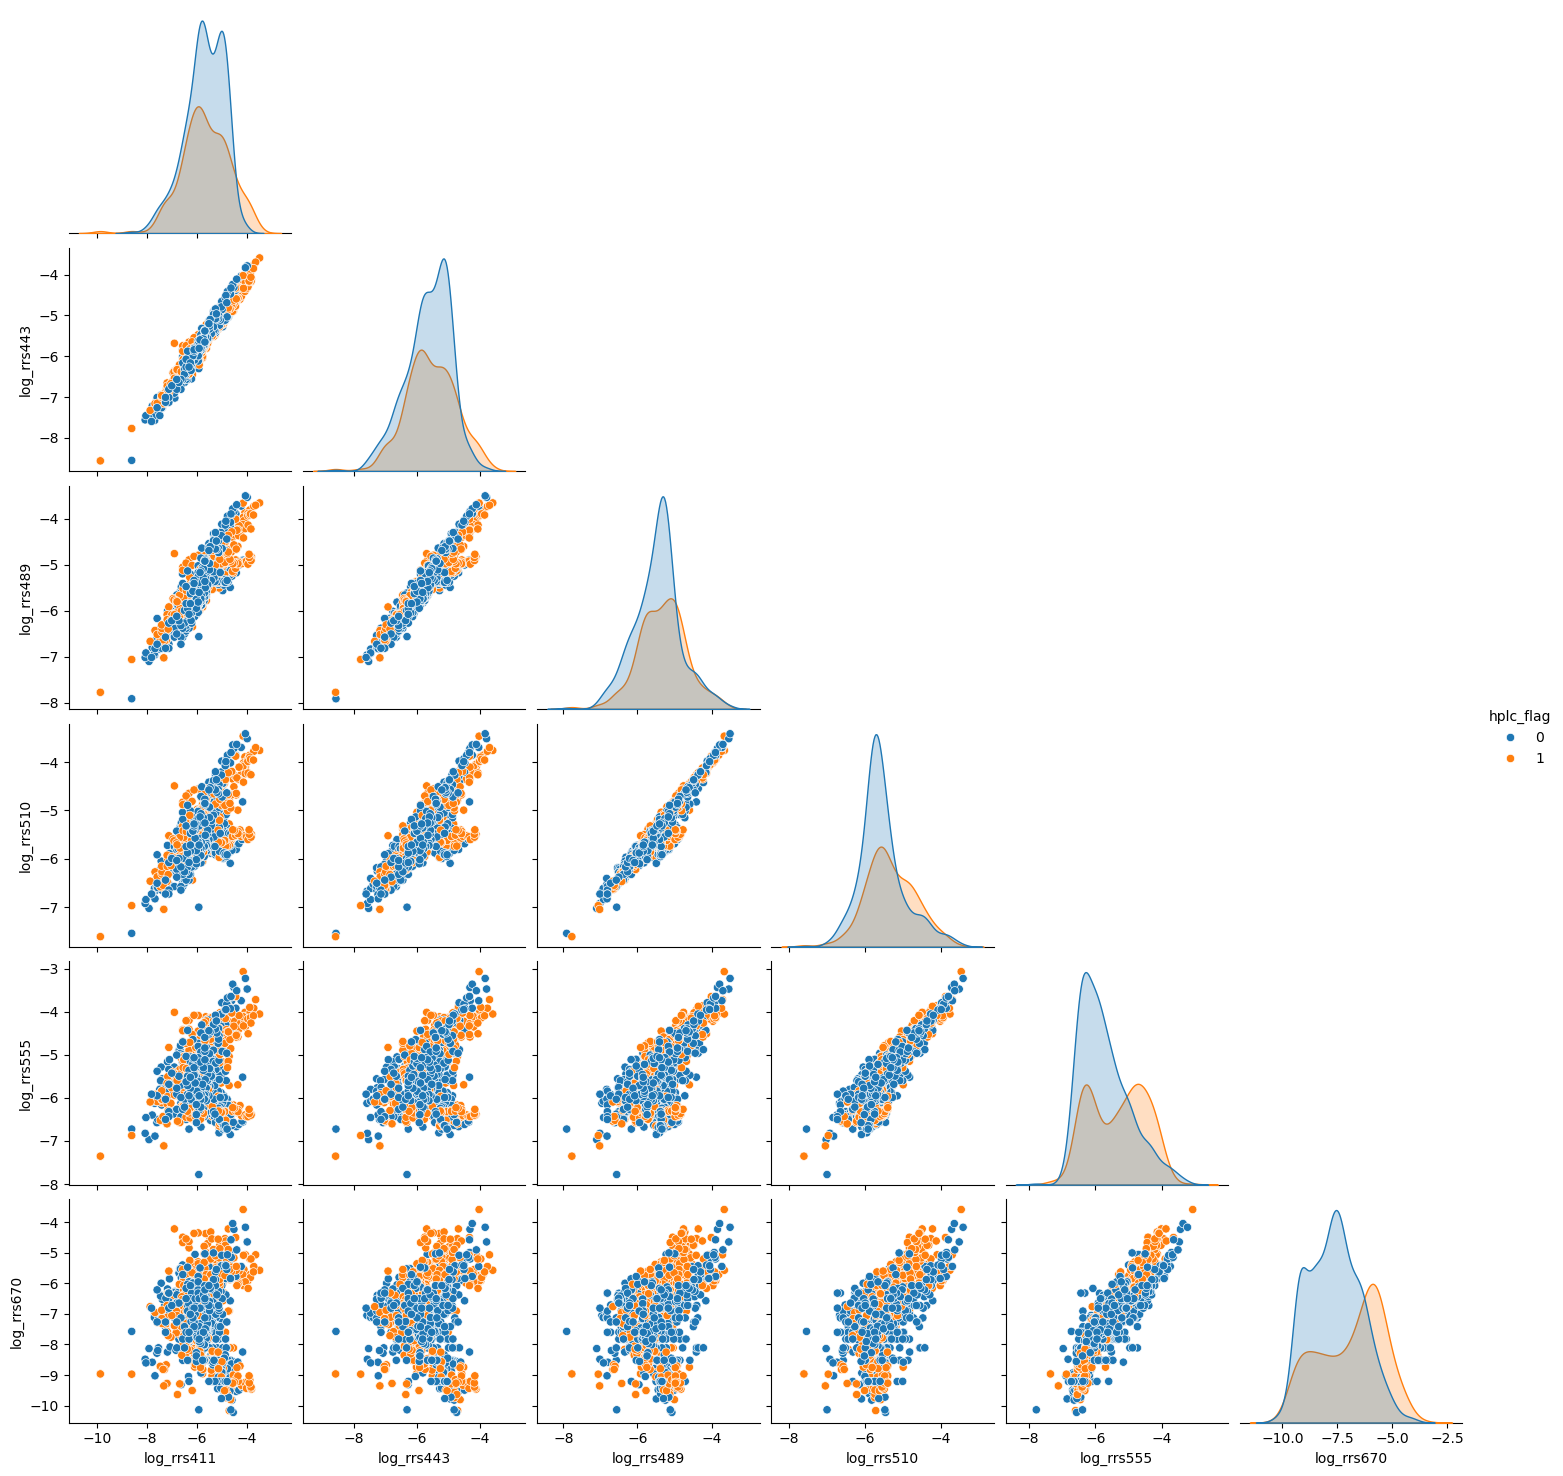

In [112]:
sb.pairplot(df_log, vars=[f'log_rrs{i}' for i in [411, 443, 489, 510, 555, 670]], hue='hplc_flag', corner=True)

In [110]:
df_log.to_parquet(project_path / 'data/04_transformed/df_log.pqt')

In [103]:
df_.to_parquet(project_path / 'data/04_transformed/df_ready4log.pqt')

<Axes: ylabel='chl'>

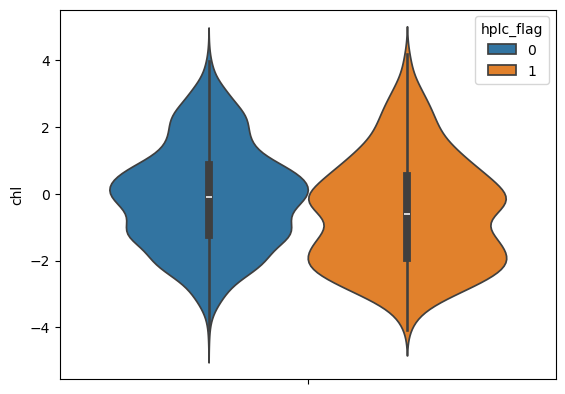

In [85]:

sb.violinplot(
    data=df_log[df_log.hplc_flag.astype('int') >=0], 
    y='chl', hue='hplc_flag')


/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


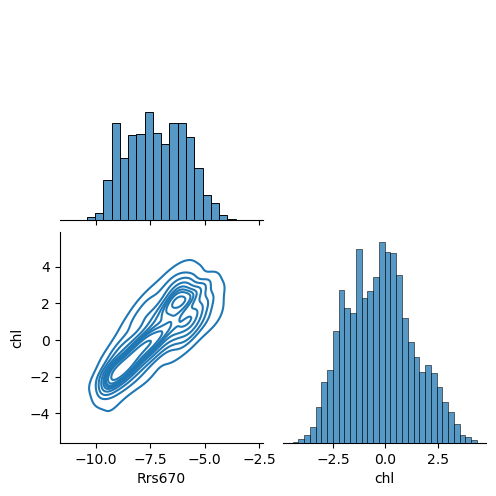

In [ ]:
sb.pairplot(np.log(df[['Rrs670', 'chl']]), corner=True, kind='kde', diag_kind='hist',);

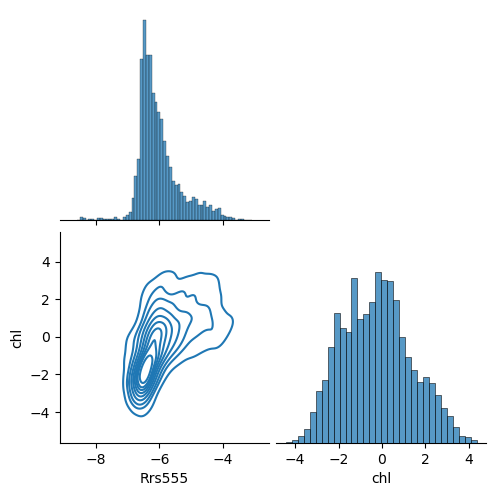

In [75]:
sb.pairplot(np.log(df[['Rrs555', 'chl']]), corner=True, kind='kde', diag_kind='hist');

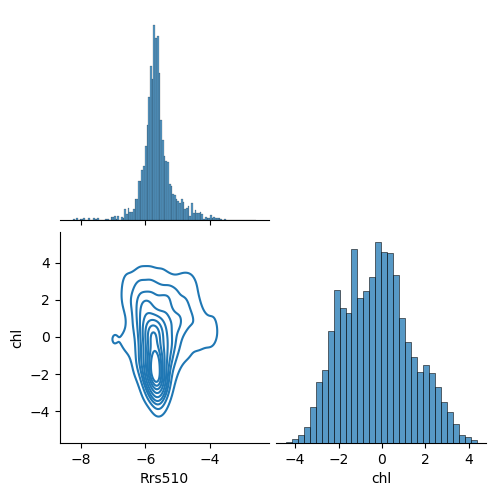

In [76]:
sb.pairplot(np.log(df[['Rrs510', 'chl']]), corner=True, kind='kde', diag_kind='hist');

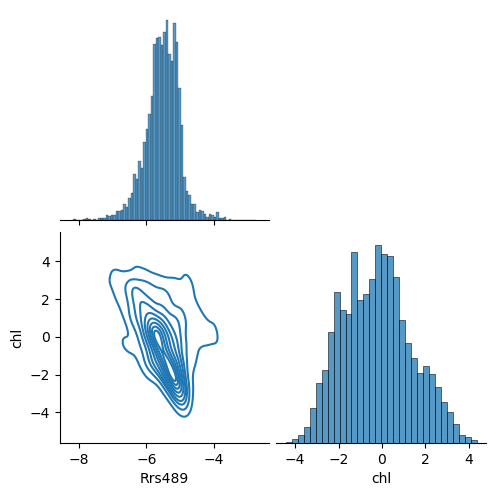

In [77]:
sb.pairplot(np.log(df[['Rrs489', 'chl']]), corner=True, kind='kde', diag_kind='hist');

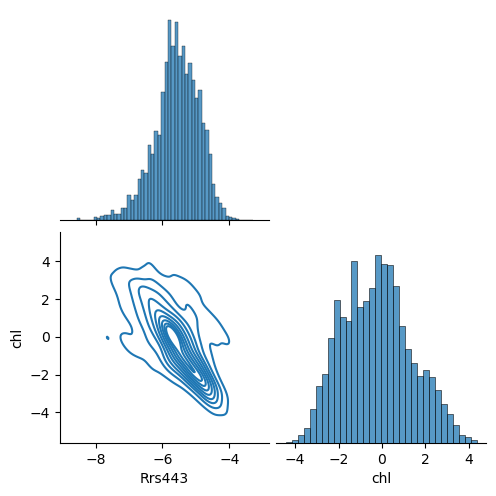

In [78]:
sb.pairplot(np.log(df[['Rrs443', 'chl']]), corner=True, kind='kde', diag_kind='hist');

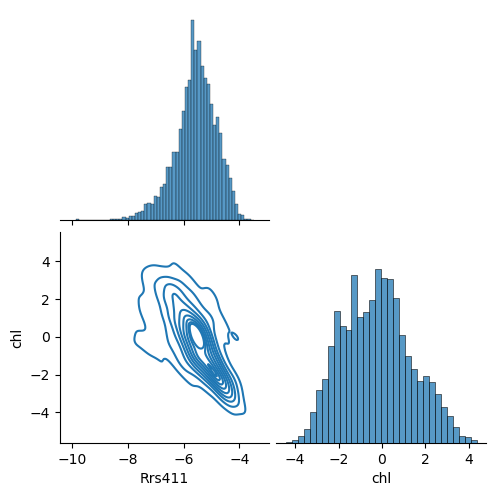

In [80]:
sb.pairplot(np.log(df[['Rrs411', 'chl']]), corner=True, kind='kde', diag_kind='hist');

In [ ]:
sb.pairplot(np.log(df[['Rrs411', 'chl', 'hplc_flag']]), vars=corner=True, kind='kde', diag_kind='hist', hue=);

count    4127.000000
mean        2.680228
std         5.758436
min         0.012000
25%         0.233325
50%         0.764000
75%         2.150000
max        77.864800
Name: chl, dtype: float64